# Rosenbrock banana

Here, we perform optimization for the Rosenbrock banana function, which does not require an AMICI model. In particular, we try several ways of specifying derivative information.

In [1]:
# install if not done yet
# %pip install pypesto --quiet

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from mpl_toolkits.mplot3d import Axes3D

import pypesto
import pypesto.visualize as visualize

%matplotlib inline

## Define the objective and problem

In [3]:
# first type of objective
objective1 = pypesto.Objective(
    fun=sp.optimize.rosen, grad=sp.optimize.rosen_der, hess=sp.optimize.rosen_hess
)

# second type of objective
def rosen2(x):
    return (sp.optimize.rosen(x), sp.optimize.rosen_der(x), sp.optimize.rosen_hess(x))


objective2 = pypesto.Objective(fun=rosen2, grad=True, hess=True)

dim_full = 10
lb = -5 * np.ones((dim_full, 1))
ub = 5 * np.ones((dim_full, 1))

problem1 = pypesto.Problem(objective=objective1, lb=lb, ub=ub)
problem2 = pypesto.Problem(objective=objective2, lb=lb, ub=ub)

### Illustration

In [4]:
x = np.arange(-2, 2, 0.1)
y = np.arange(-2, 2, 0.1)
x, y = np.meshgrid(x, y)
z = np.zeros_like(x)
for j in range(0, x.shape[0]):
    for k in range(0, x.shape[1]):
        z[j, k] = objective1([x[j, k], y[j, k]], (0,))

Text(0.5, 0.92, 'cost function values')

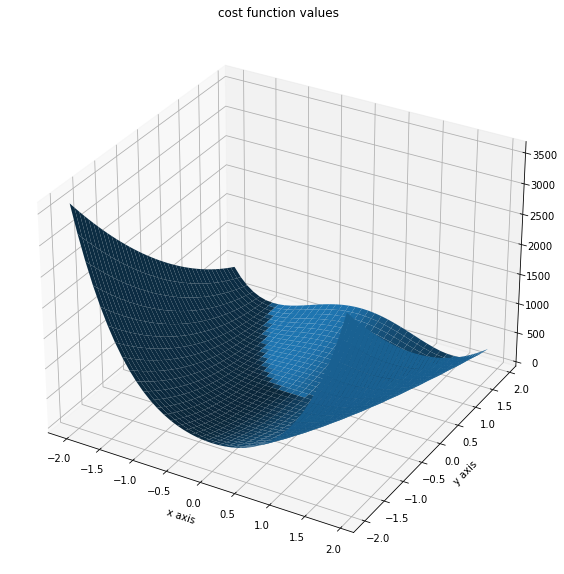

In [5]:
fig = plt.figure()
fig.set_size_inches(*(14, 10))
ax = plt.axes(projection="3d")
ax.plot_surface(X=x, Y=y, Z=z)
plt.xlabel("x axis")
plt.ylabel("y axis")
ax.set_title("cost function values")

## Run optimization

In [6]:
import pypesto.optimize as optimize

In [7]:
# create different optimizers
optimizer_bfgs = optimize.ScipyOptimizer(method="l-bfgs-b")
optimizer_tnc = optimize.ScipyOptimizer(method="TNC")
optimizer_dogleg = optimize.ScipyOptimizer(method="dogleg")

# set number of starts
n_starts = 20

# save optimizer trace
history_options = pypesto.HistoryOptions(trace_record=True)

# Run optimizaitons for different optimzers
result1_bfgs = optimize.minimize(
    problem=problem1,
    optimizer=optimizer_bfgs,
    n_starts=n_starts,
    history_options=history_options,
    filename=None,
)
result1_tnc = optimize.minimize(
    problem=problem1,
    optimizer=optimizer_tnc,
    n_starts=n_starts,
    history_options=history_options,
    filename=None,
)
result1_dogleg = optimize.minimize(
    problem=problem1,
    optimizer=optimizer_dogleg,
    n_starts=n_starts,
    history_options=history_options,
    filename=None,
)

# Optimize second type of objective
result2 = optimize.minimize(
    problem=problem2, optimizer=optimizer_tnc, n_starts=n_starts, filename=None
)

100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.49it/s]


### Visualize and compare optimization results

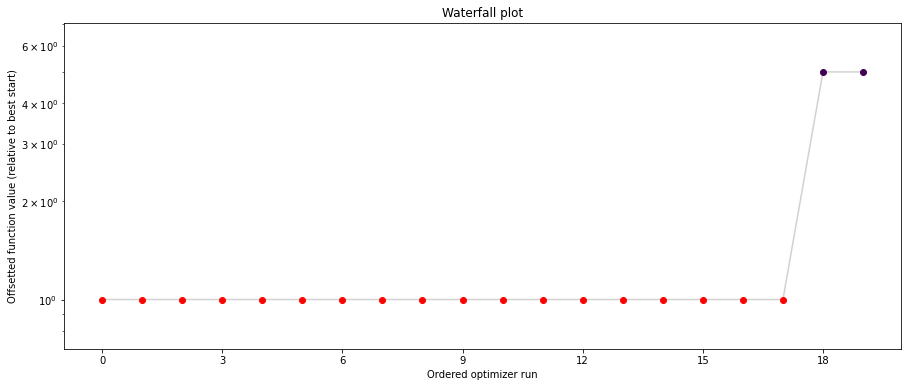

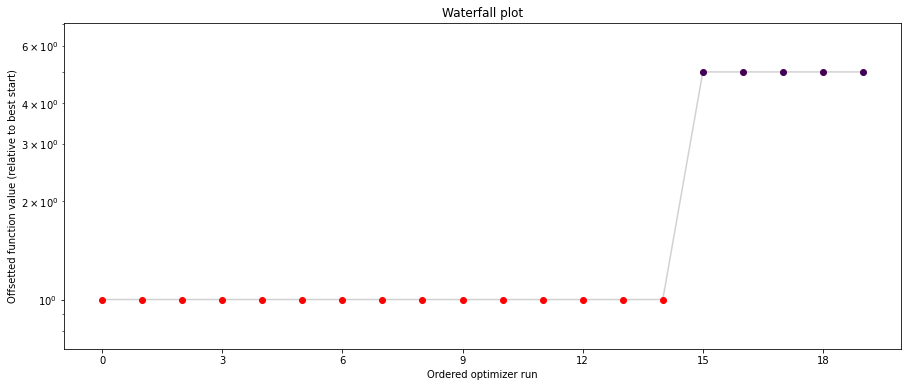

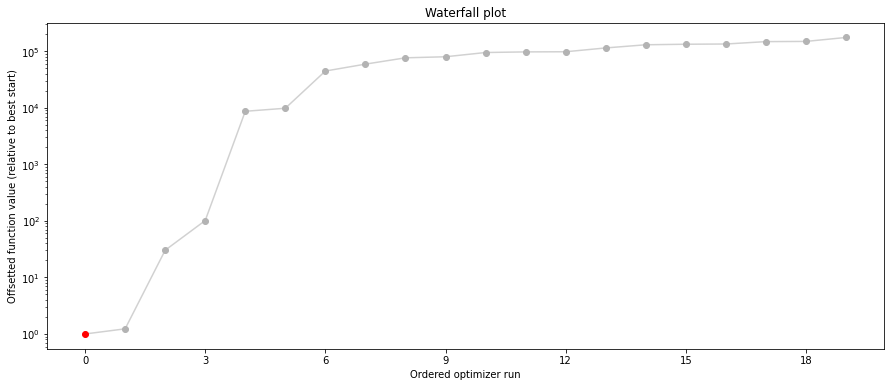

In [8]:
# plot separated waterfalls
visualize.waterfall(result1_bfgs, size=(15, 6))
visualize.waterfall(result1_tnc, size=(15, 6))
visualize.waterfall(result1_dogleg, size=(15, 6));

We can now have a closer look, which method perfomred better: Let's first compare bfgs and TNC, since both methods gave good results. How does the fine convergence look like?

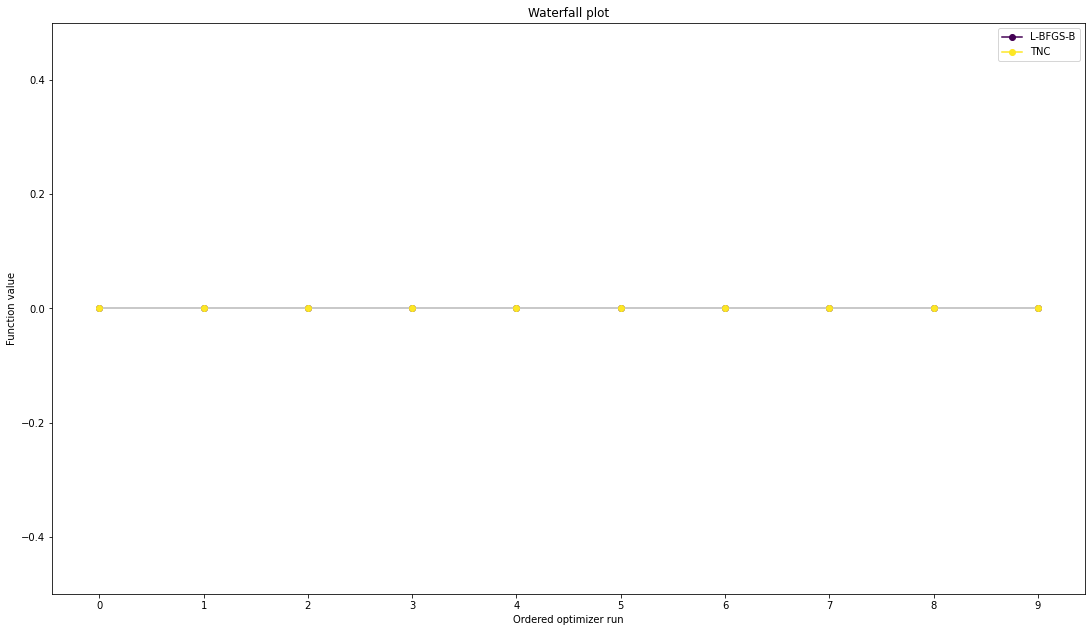

In [9]:
# plot one list of waterfalls
visualize.waterfall(
    [result1_bfgs, result1_tnc],
    legends=["L-BFGS-B", "TNC"],
    start_indices=10,
    scale_y="lin",
);

Second optimum at: 3.986579112988829


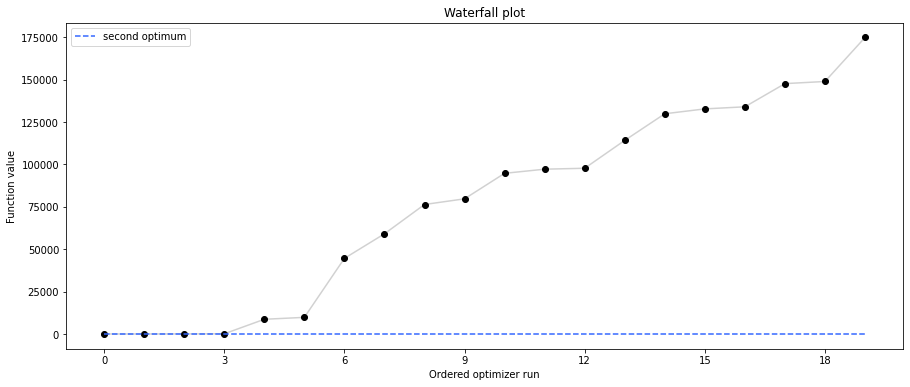

In [10]:
# retrieve second optimum
all_x = result1_bfgs.optimize_result.get_for_key("x")
all_fval = result1_bfgs.optimize_result.get_for_key("fval")
x = all_x[19]
fval = all_fval[19]
print("Second optimum at: " + str(fval))

# create a reference point from it
ref = {"x": x, "fval": fval, "color": [0.2, 0.4, 1.0, 1.0], "legend": "second optimum"}
ref = visualize.create_references(ref)

# new waterfall plot with reference point for second optimum
visualize.waterfall(
    result1_dogleg,
    size=(15, 6),
    scale_y="lin",
    y_limits=[-1, 101],
    reference=ref,
    colors=[0.0, 0.0, 0.0, 1.0],
);

## Visualize parameters

There seems to be a second local optimum. We want to see whether it was also found by the dogleg method

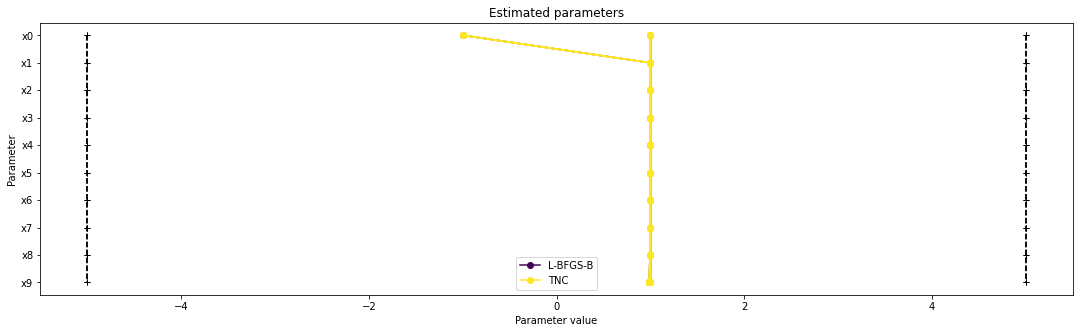

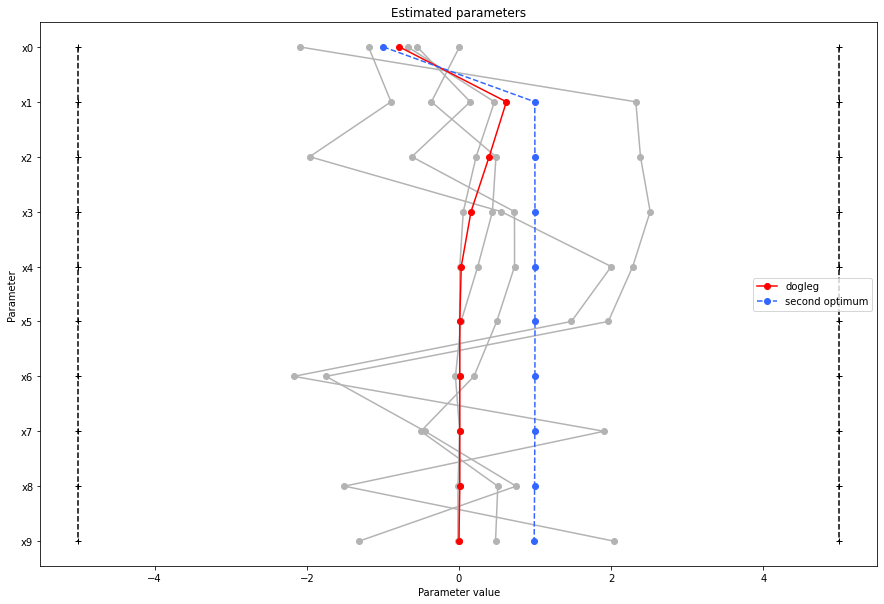

In [11]:
visualize.parameters(
    [result1_bfgs, result1_tnc],
    legends=["L-BFGS-B", "TNC"],
    balance_alpha=False,
)
visualize.parameters(
    result1_dogleg,
    legends="dogleg",
    reference=ref,
    size=(15, 10),
    start_indices=[0, 1, 2, 3, 4, 5],
    balance_alpha=False,
);

If the result needs to be examined in more detail, it can easily be exported as a pandas.DataFrame:

In [12]:
df = result1_tnc.optimize_result.as_dataframe(
    ["fval", "n_fval", "n_grad", "n_hess", "n_res", "n_sres", "time"],
)
df.head()

,fval,n_fval,n_grad,n_hess,n_res,n_sres,time
0,1.700177e-12,234,234,0,0,0,0.095119
1,5.863075e-12,254,254,0,0,0,0.102610
2,6.024982e-12,201,201,0,0,0,0.074668
3,1.022637e-11,231,231,0,0,0,0.086636
4,1.491191e-11,170,170,0,0,0,0.072328


### Optimizer history

Let's compare optimzer progress over time.

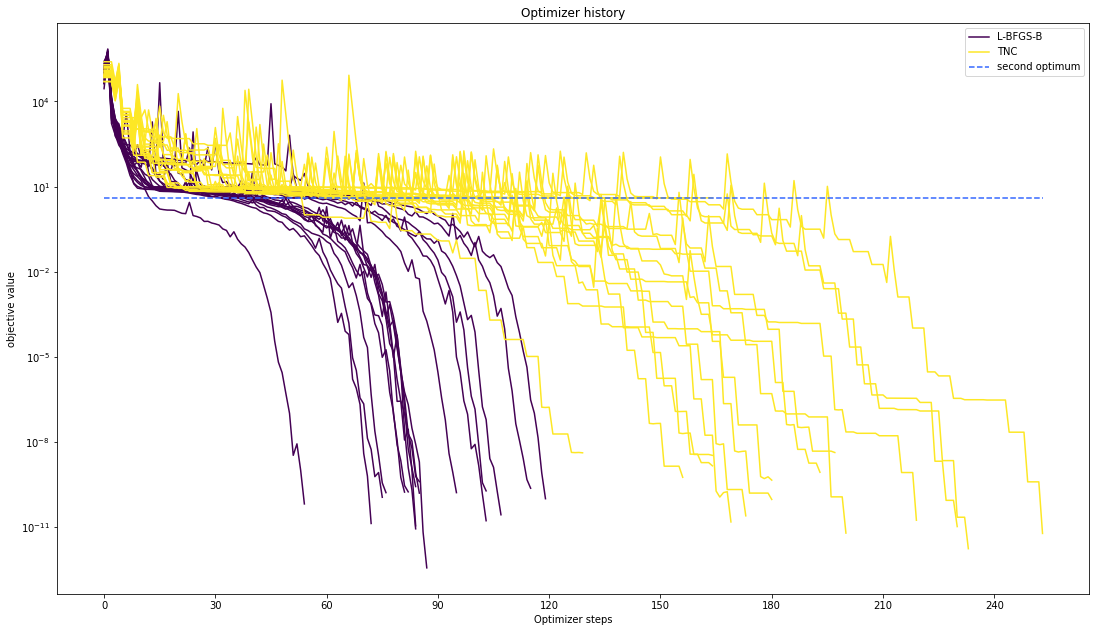

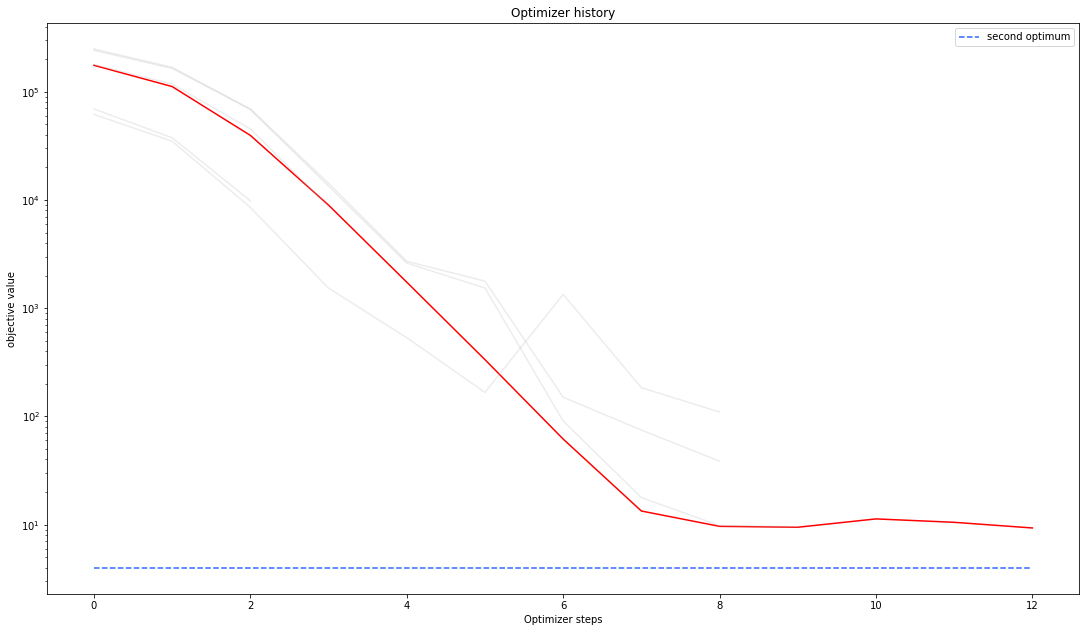

In [13]:
# plot one list of waterfalls
visualize.optimizer_history(
    [result1_bfgs, result1_tnc],
    legends=["L-BFGS-B", "TNC"],
    reference=ref,
)
# plot one list of waterfalls
visualize.optimizer_history(
    result1_dogleg,
    reference=ref,
);

We can also visualize this usign other scalings or offsets...

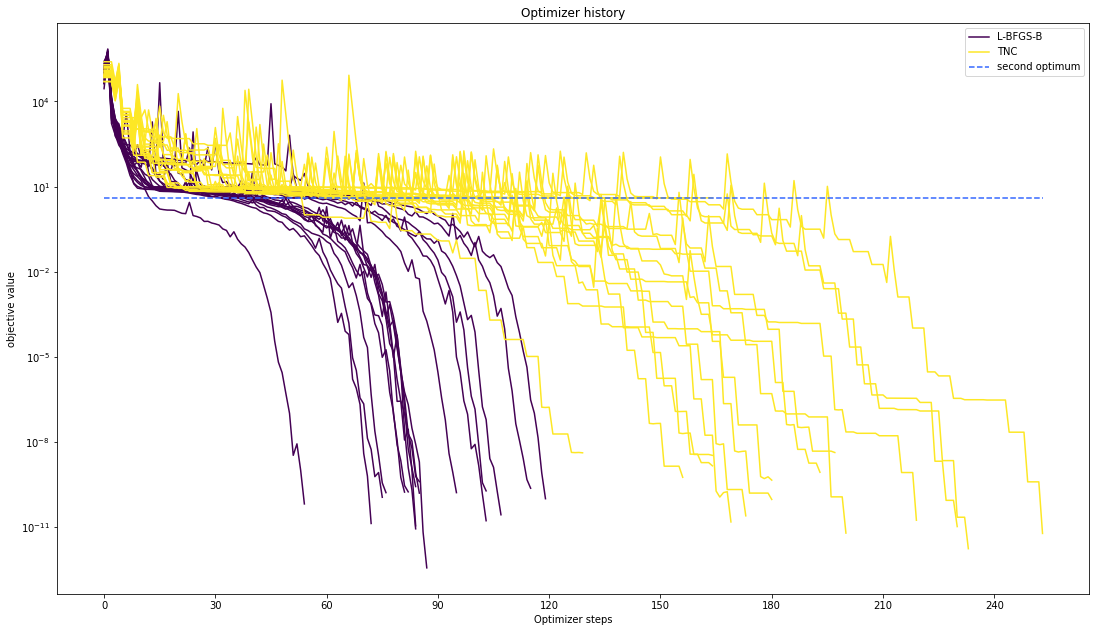

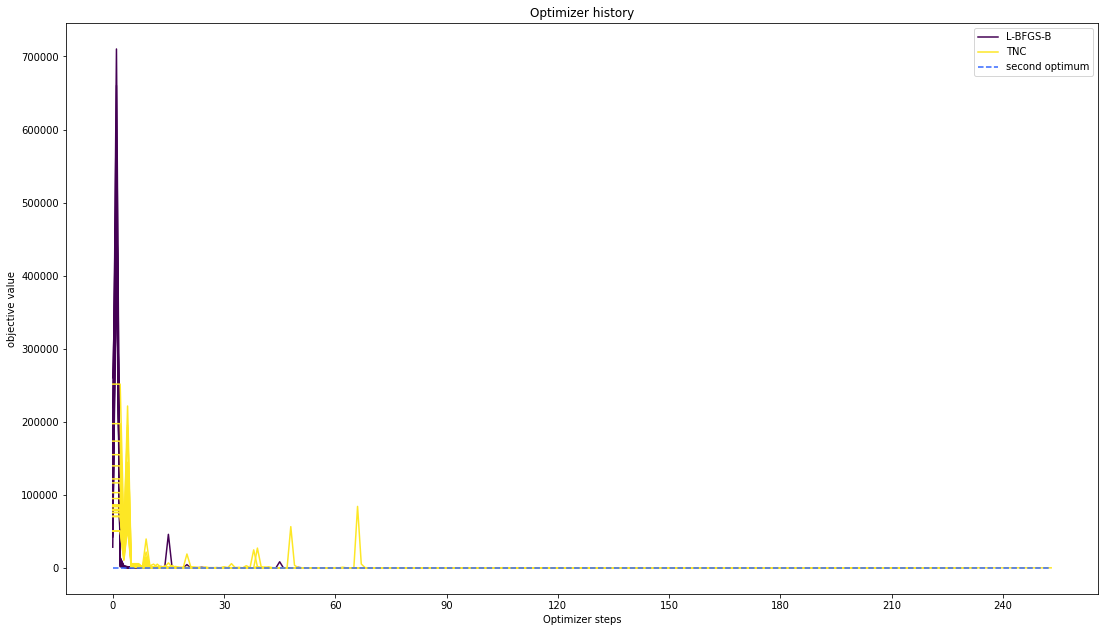

In [14]:
# plot one list of waterfalls
visualize.optimizer_history(
    [result1_bfgs, result1_tnc],
    legends=["L-BFGS-B", "TNC"],
    reference=ref,
    offset_y=0.0,
)

# plot one list of waterfalls
visualize.optimizer_history(
    [result1_bfgs, result1_tnc],
    legends=["L-BFGS-B", "TNC"],
    reference=ref,
    scale_y="lin",
    y_limits=[-1.0, 11.0],
);

## Compute profiles

The profiling routine needs a problem, a results object and an optimizer.

Moreover it accepts an index of integer (profile_index), whether or not a profile should be computed.

Finally, an integer (result_index) can be passed, in order to specify the local optimum, from which profiling should be started.

In [15]:
import pypesto.profile as profile

In [16]:
# compute profiles
profile_options = profile.ProfileOptions(
    min_step_size=0.0005,
    delta_ratio_max=0.05,
    default_step_size=0.005,
    ratio_min=0.01,
)

result1_bfgs = profile.parameter_profile(
    problem=problem1,
    result=result1_bfgs,
    optimizer=optimizer_bfgs,
    profile_index=np.array([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]),
    result_index=0,
    profile_options=profile_options,
    filename=None,
)

# compute profiles from second optimum
result1_bfgs = profile.parameter_profile(
    problem=problem1,
    result=result1_bfgs,
    optimizer=optimizer_bfgs,
    profile_index=np.array([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]),
    result_index=19,
    profile_options=profile_options,
    filename=None,
)

100%|█████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 86.06it/s]


### Visualize and analyze results

pypesto offers easy-to-use visualization routines:

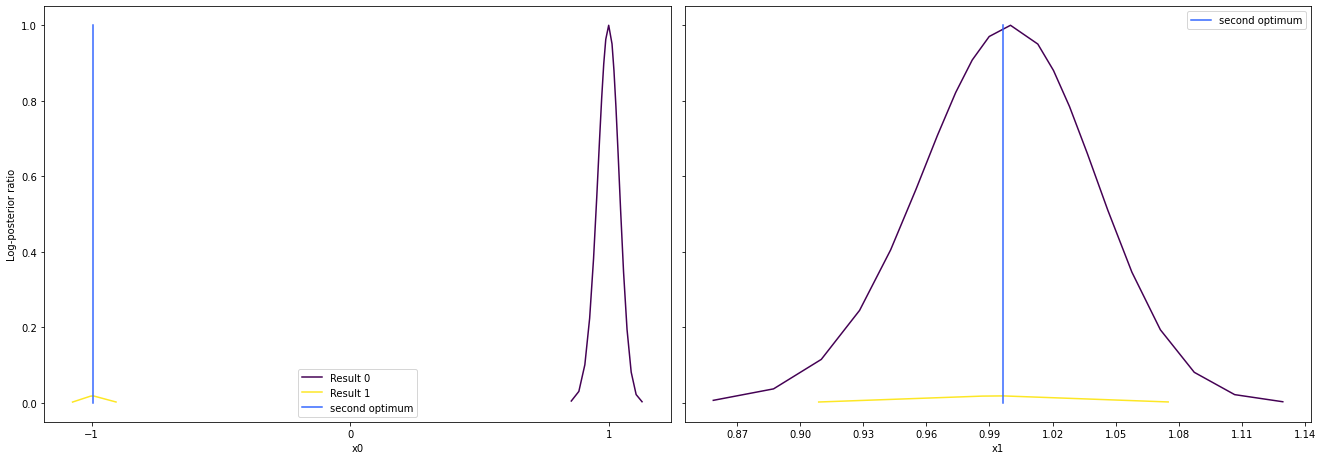

In [17]:
# specify the parameters, for which profiles should be computed
ax = visualize.profiles(
    result1_bfgs,
    profile_indices=[0, 1, 2, 5, 7],
    reference=ref,
    profile_list_ids=[0, 1],
);

### Approximate profiles

When computing the profiles is computationally too demanding, it is possible to employ to at least consider a normal approximation with covariance matrix given by the Hessian or FIM at the optimal parameters.

In [18]:
result1_tnc = profile.approximate_parameter_profile(
    problem=problem1,
    result=result1_bfgs,
    profile_index=np.array([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]),
    result_index=0,
    n_steps=1000,
)

Computing Hessian/FIM as not available in result.


These approximate profiles require at most one additional function evaluation, can however yield substantial approximation errors:

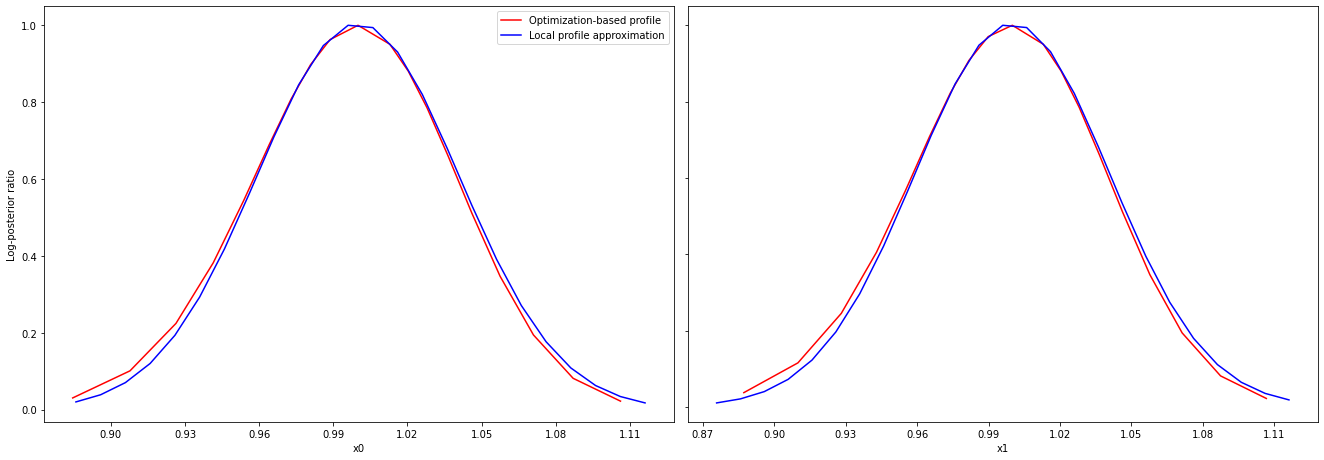

In [19]:
axes = visualize.profiles(
    result1_bfgs,
    profile_indices=[0, 1, 2, 5, 7],
    profile_list_ids=[0, 2],
    ratio_min=0.01,
    colors=[(1, 0, 0, 1), (0, 0, 1, 1)],
    legends=[
        "Optimization-based profile",
        "Local profile approximation",
    ],
);

We can also plot approximate confidence intervals based on profiles:

<AxesSubplot:xlabel='Parameter value', ylabel='Parameter'>

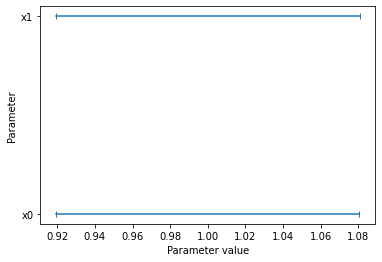

In [20]:
visualize.profile_cis(
    result1_bfgs,
    confidence_level=0.95,
    profile_list=2,
)